# Packages import

In [291]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras
import seaborn as sns

import random

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score
from tensorflow.keras import layers

from os import listdir
from sklearn.preprocessing import LabelBinarizer 

# Accelerometer and gyroscope

## Import and process data

In [39]:
data_train = pd.read_csv('train_motion_data.csv')
data_test = pd.read_csv('test_motion_data.csv')

In [40]:
is_number = np.vectorize(lambda x: np.issubdtype(x, np.number))
train_mask = is_number(data_train.dtypes)
test_mask = is_number(data_train.dtypes)

print('No gaps' if pd.api.types.is_numeric_dtype(data_train) and pd.api.types.is_numeric_dtype(data_test) else 'Replace some data in column', data_train.columns[~train_mask], data_test.columns[~test_mask])

Replace some data in column Index(['Class'], dtype='object') Index(['Class'], dtype='object')


Replace data that first column will be a Class data

In [41]:
data_train = data_train[['Class'] + [x for x in data_test.columns if x != 'Class']]
data_test = data_test[['Class'] + [x for x in data_test.columns if x != 'Class']]

In [42]:
data_train

Class      AccX      AccY      AccZ     GyroX     GyroY     GyroZ  \
0     NORMAL  0.000000  0.000000  0.000000  0.059407 -0.174707  0.101938   
1     NORMAL -1.624864 -1.082492 -0.204183 -0.028558  0.051313  0.135536   
2     NORMAL -0.594660 -0.122410  0.220502 -0.019395 -0.029322  0.087888   
3     NORMAL  0.738478 -0.228456  0.667732  0.069791 -0.029932  0.054902   
4     NORMAL  0.101741  0.777568 -0.066730  0.030696 -0.003665  0.054902   
...      ...       ...       ...       ...       ...       ...       ...   
3639    SLOW  0.915688 -2.017489  1.687505  0.450360  0.384845 -1.236468   
3640    SLOW -1.934203  0.914925 -0.096013  0.321468  0.649350 -0.477162   
3641    SLOW -0.222845  0.747304 -0.887430  0.361174 -0.406836  0.054291   
3642    SLOW -0.349423  0.067261  0.394368 -0.132405  0.020159 -0.004963   
3643    SLOW -0.402428  0.406218 -0.423009 -0.053603 -0.006720  0.001145   

      Timestamp  
0       3581629  
1       3581630  
2       3581630  
3       3581631  
4       3581631  
...         ...  
3639    3583789  
3640    3583790  
3641    3583790  
3642    3583791  
3643    3583791  

[3644 rows x 8 columns]

Normalizing time unit for more informatives graphs

In [43]:
data_train['Timestamp'] = data_train['Timestamp'] - data_train['Timestamp'].min()
data_test['Timestamp'] = data_test['Timestamp'] - data_test['Timestamp'].min()

Separate data for their classes

In [44]:
train_normal = data_train.loc[data_train['Class'] == 'NORMAL']
train_slow = data_train.loc[data_train['Class'] == 'SLOW']
train_aggressive = data_train.loc[data_train['Class'] == 'AGGRESSIVE']

test_normal = data_test.loc[data_test['Class'] == 'NORMAL']
test_slow = data_test.loc[data_test['Class'] == 'SLOW']
test_aggressive = data_test.loc[data_test['Class'] == 'AGGRESSIVE']

In [45]:
train_normal

Class      AccX      AccY      AccZ     GyroX     GyroY     GyroZ  \
0     NORMAL  0.000000  0.000000  0.000000  0.059407 -0.174707  0.101938   
1     NORMAL -1.624864 -1.082492 -0.204183 -0.028558  0.051313  0.135536   
2     NORMAL -0.594660 -0.122410  0.220502 -0.019395 -0.029322  0.087888   
3     NORMAL  0.738478 -0.228456  0.667732  0.069791 -0.029932  0.054902   
4     NORMAL  0.101741  0.777568 -0.066730  0.030696 -0.003665  0.054902   
...      ...       ...       ...       ...       ...       ...       ...   
1195  NORMAL -0.820672  2.556599 -0.617599 -0.031612 -0.865596 -0.962189   
1196  NORMAL -0.016871  1.171574  0.603792  0.253662  0.692110  0.537485   
1197  NORMAL  2.488864 -1.001262  0.432143  0.140041 -0.080023  0.051847   
1198  NORMAL -0.680338 -0.048300 -3.298533 -0.169057 -0.383012  0.217392   
1199  NORMAL  0.563353  1.234707 -0.729512  0.226784 -1.290758 -0.309174   

      Timestamp  
0             0  
1             1  
2             1  
3             2  
4             2  
...         ...  
1195        645  
1196        646  
1197        646  
1198        647  
1199        647  

[1200 rows x 8 columns]

In [46]:
test_normal

Class      AccX      AccY      AccZ     GyroX     GyroY     GyroZ  \
814   NORMAL  0.697619  0.105949  0.331605  0.083689  0.000840  0.050549   
815   NORMAL  1.124378  4.308813 -1.341221  0.006720  0.002673 -0.002596   
816   NORMAL -0.217551  0.020554  0.070902  0.003054 -0.004047  0.004123   
817   NORMAL  0.367346  0.377823  0.020036  0.001222 -0.073686  0.011454   
818   NORMAL -0.113025 -0.038479  0.146810  0.001833  0.004505 -0.017868   
...      ...       ...       ...       ...       ...       ...       ...   
1806  NORMAL  1.416944 -1.247972 -0.623418  1.490511  0.917138 -0.976315   
1807  NORMAL  0.324851 -2.679708  1.041722  0.502742  0.657520  0.315665   
1808  NORMAL  1.073423 -2.018279  0.978626  0.117897 -0.869643  0.040164   
1809  NORMAL -0.828570 -2.477492  4.760305  0.131336  0.312381  0.222813   
1810  NORMAL  1.037600 -0.933241  0.079969  0.136834 -0.068799 -0.049022   

      Timestamp  
814         518  
815         518  
816         519  
817         520  
818         520  
...         ...  
1806       1054  
1807       1054  
1808       1055  
1809       1055  
1810       1056  

[997 rows x 8 columns]

## Print data in fancy figures

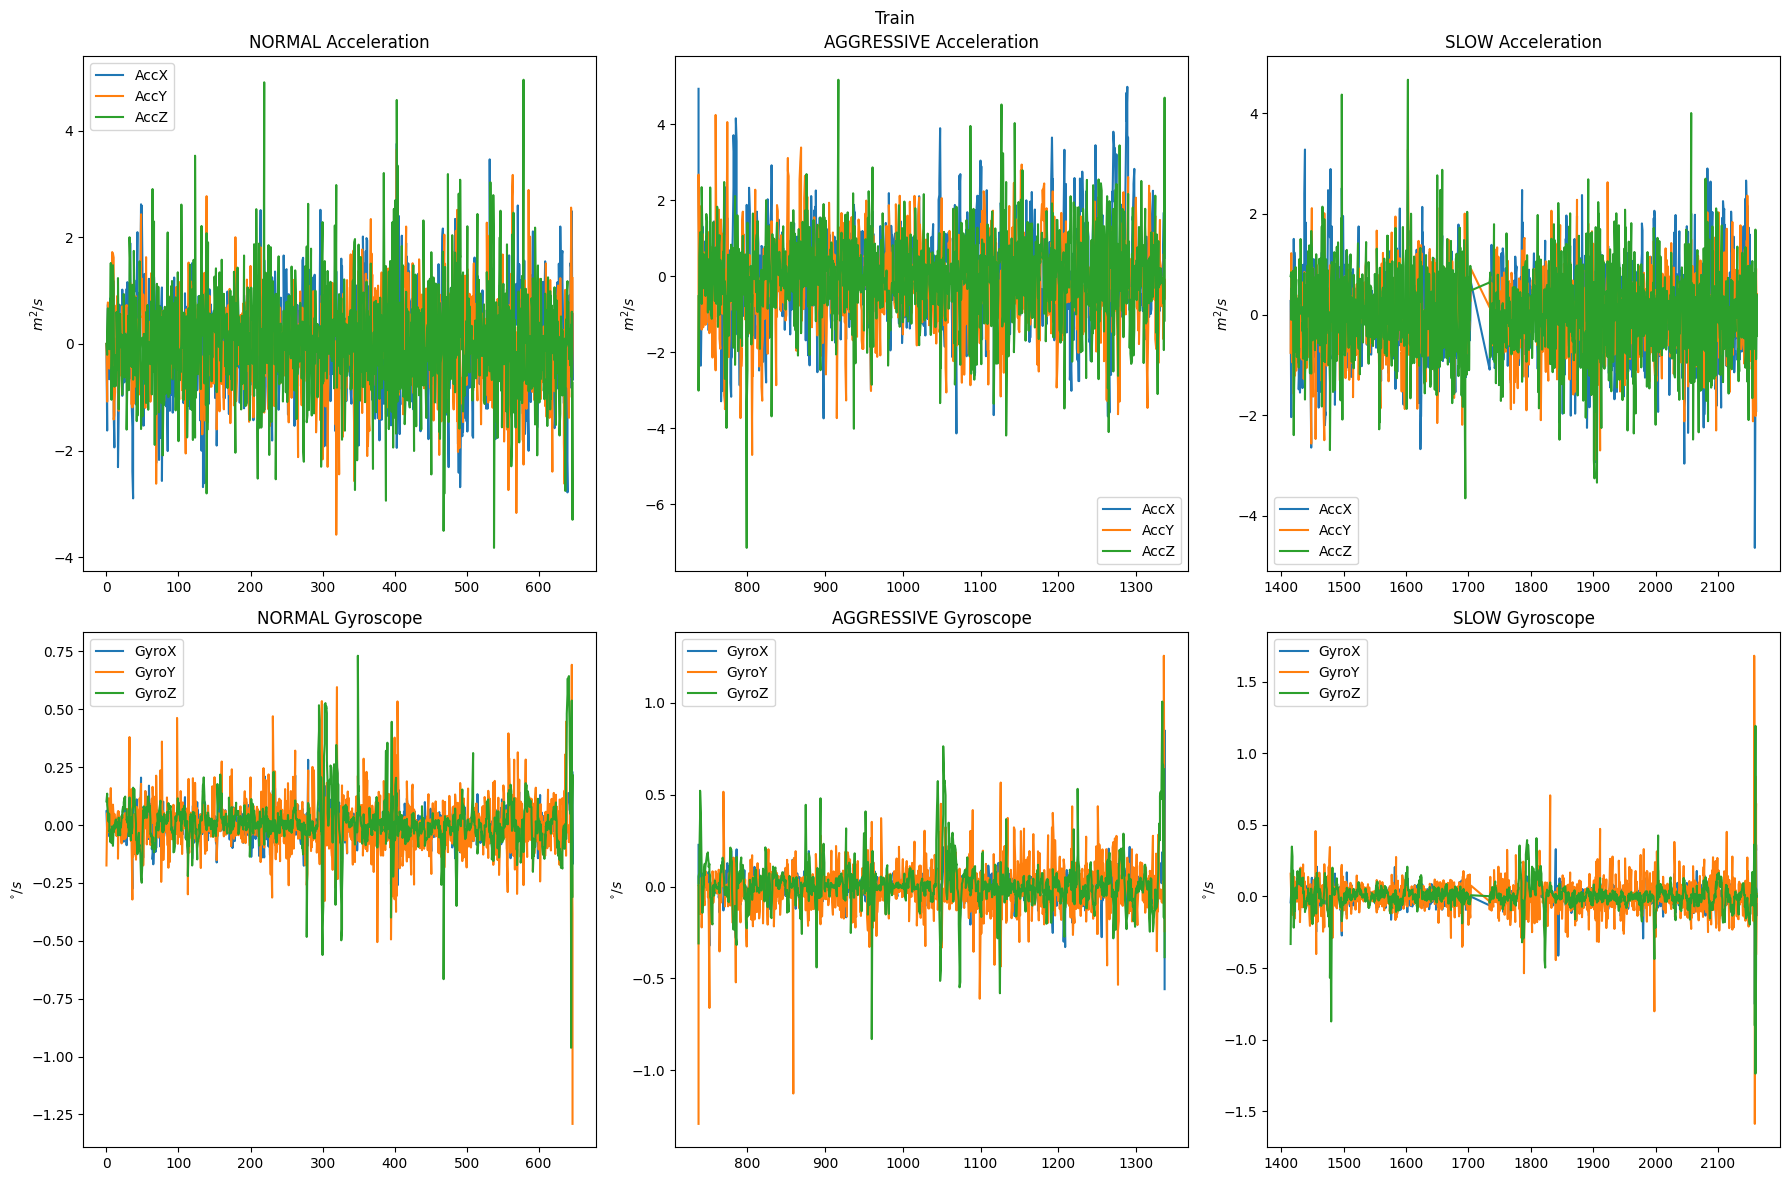

In [47]:
fig, axs = plt.subplots(2, 3, figsize=(18, 12))

classes_train = [train_normal, train_aggressive, train_slow]
graph = ['Acc', 'Gyro']
names = ['Acceleration', 'Gyroscope']
units = ['$m^2/s$', '$^{\circ}/s$']

fig.suptitle('Train')

for i in range(len(graph)):
    for j, ax in enumerate(axs.flatten()[i*3:3+i*3]):
        ax.plot(classes_train[j]['Timestamp'], classes_train[j][graph[i]+'X'], label= graph[i] + 'X')
        ax.plot(classes_train[j]['Timestamp'], classes_train[j][graph[i]+'Y'], label= graph[i] + 'Y')
        ax.plot(classes_train[j]['Timestamp'], classes_train[j][graph[i]+'Z'], label= graph[i] + 'Z')
        ax.set_title(classes_train[j]['Class'].iloc[0]+' '+names[i])
        ax.set_ylabel(r""+units[i])
        ax.legend()

plt.tight_layout()
plt.show()

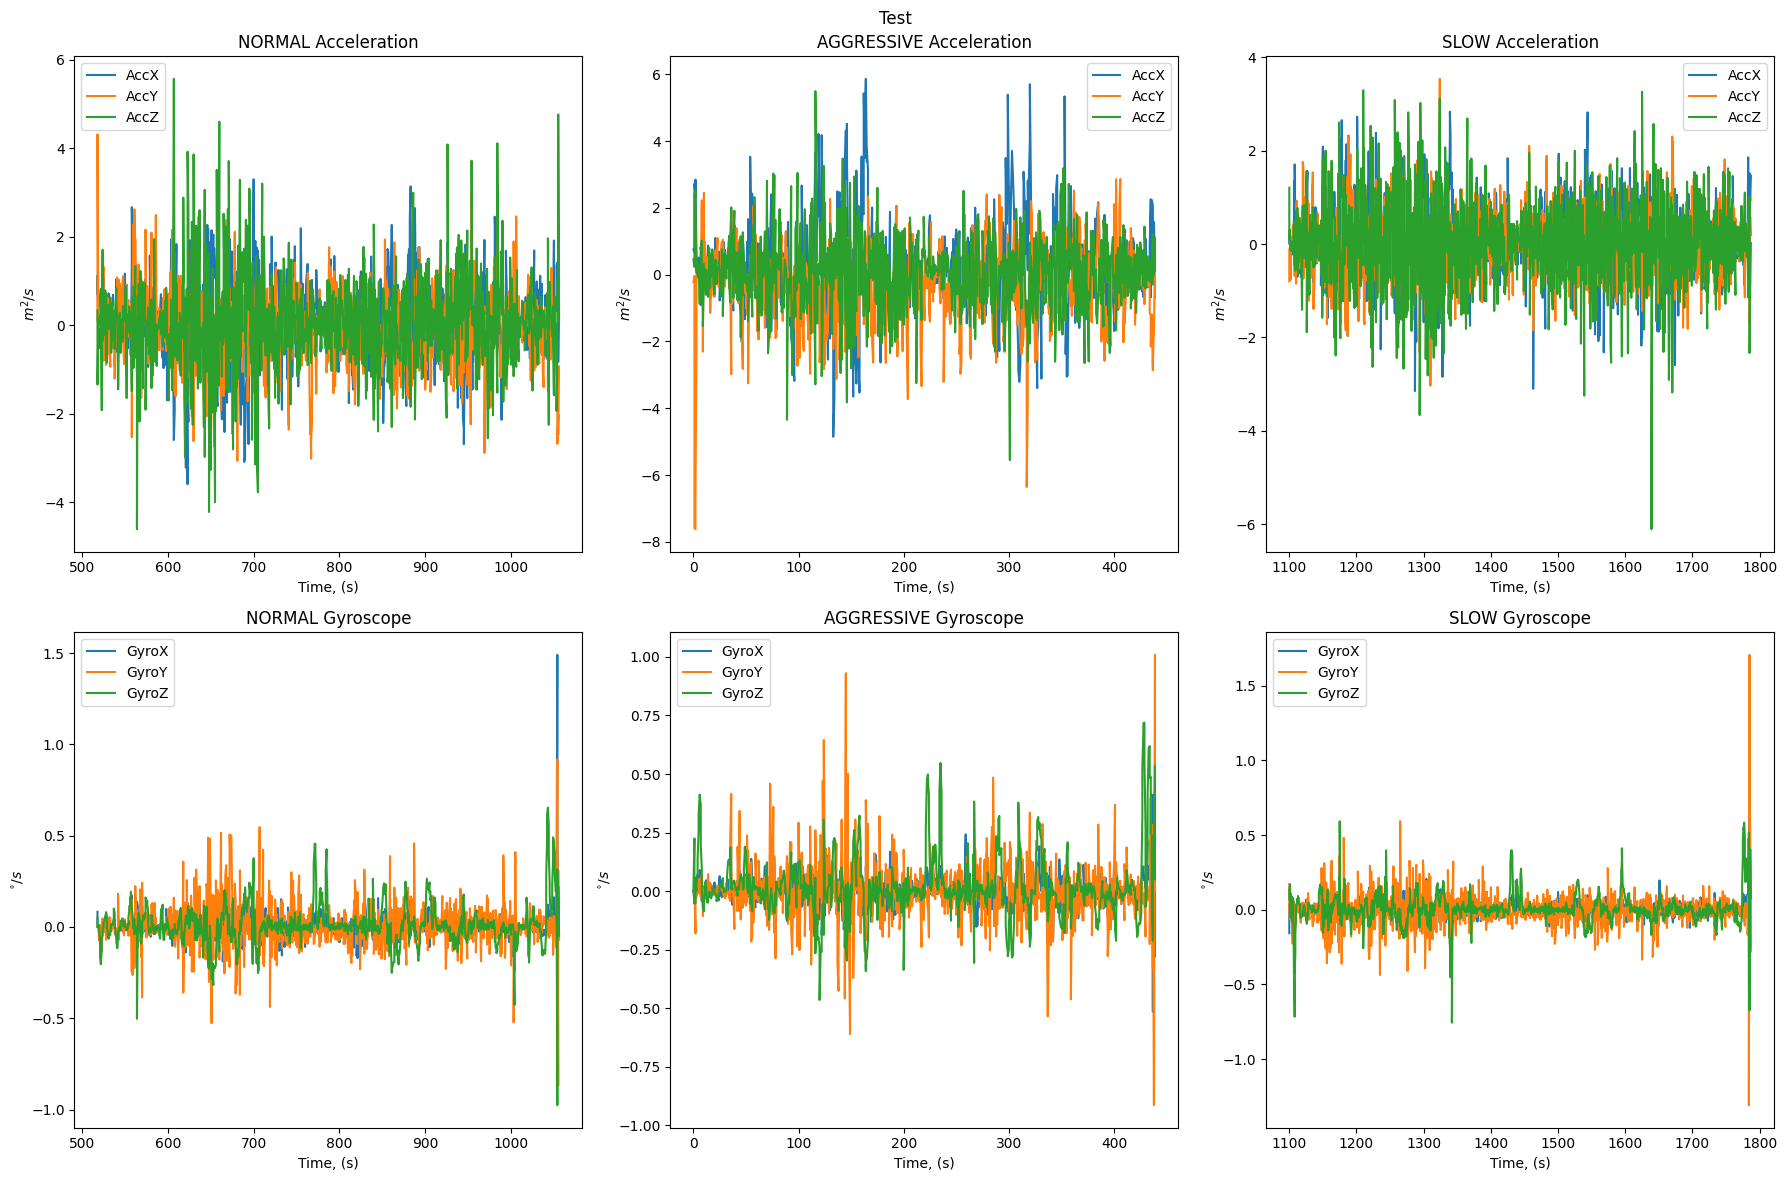

In [48]:
fig, axs = plt.subplots(2, 3, figsize=(18, 12))

classes_test = [test_normal, test_aggressive, test_slow]

fig.suptitle('Test')

for i in range(len(graph)):
    for j, ax in enumerate(axs.flatten()[i*3:3+i*3]):
        ax.plot(classes_test[j]['Timestamp'], classes_test[j][graph[i]+'X'], label= graph[i] + 'X')
        ax.plot(classes_test[j]['Timestamp'], classes_test[j][graph[i]+'Y'], label= graph[i] + 'Y')
        ax.plot(classes_test[j]['Timestamp'], classes_test[j][graph[i]+'Z'], label= graph[i] + 'Z')
        ax.set_title(classes_test[j]['Class'].iloc[0]+' '+names[i])
        ax.set_xlabel('Time, (s)')
        ax.set_ylabel(r""+units[i])
        ax.legend()

plt.tight_layout()
plt.show()

In [49]:
from scipy.signal import savgol_filter

def vec_length(x, y, z):
    return np.round((x**2 + y**2 + z**2)**0.5,4)

C:\Users\penai\AppData\Local\Temp\ipykernel_15600\2350028181.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  classes_train[i].loc[:,('Acc_vec')] = savgol_filter(acc_length_train, 10, 2)
C:\Users\penai\AppData\Local\Temp\ipykernel_15600\2350028181.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  classes_test[i].loc[:,('Acc_vec')] = savgol_filter(acc_length_test, 10, 2)
C:\Users\penai\AppData\Local\Temp\ipykernel_15600\2350028181.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a

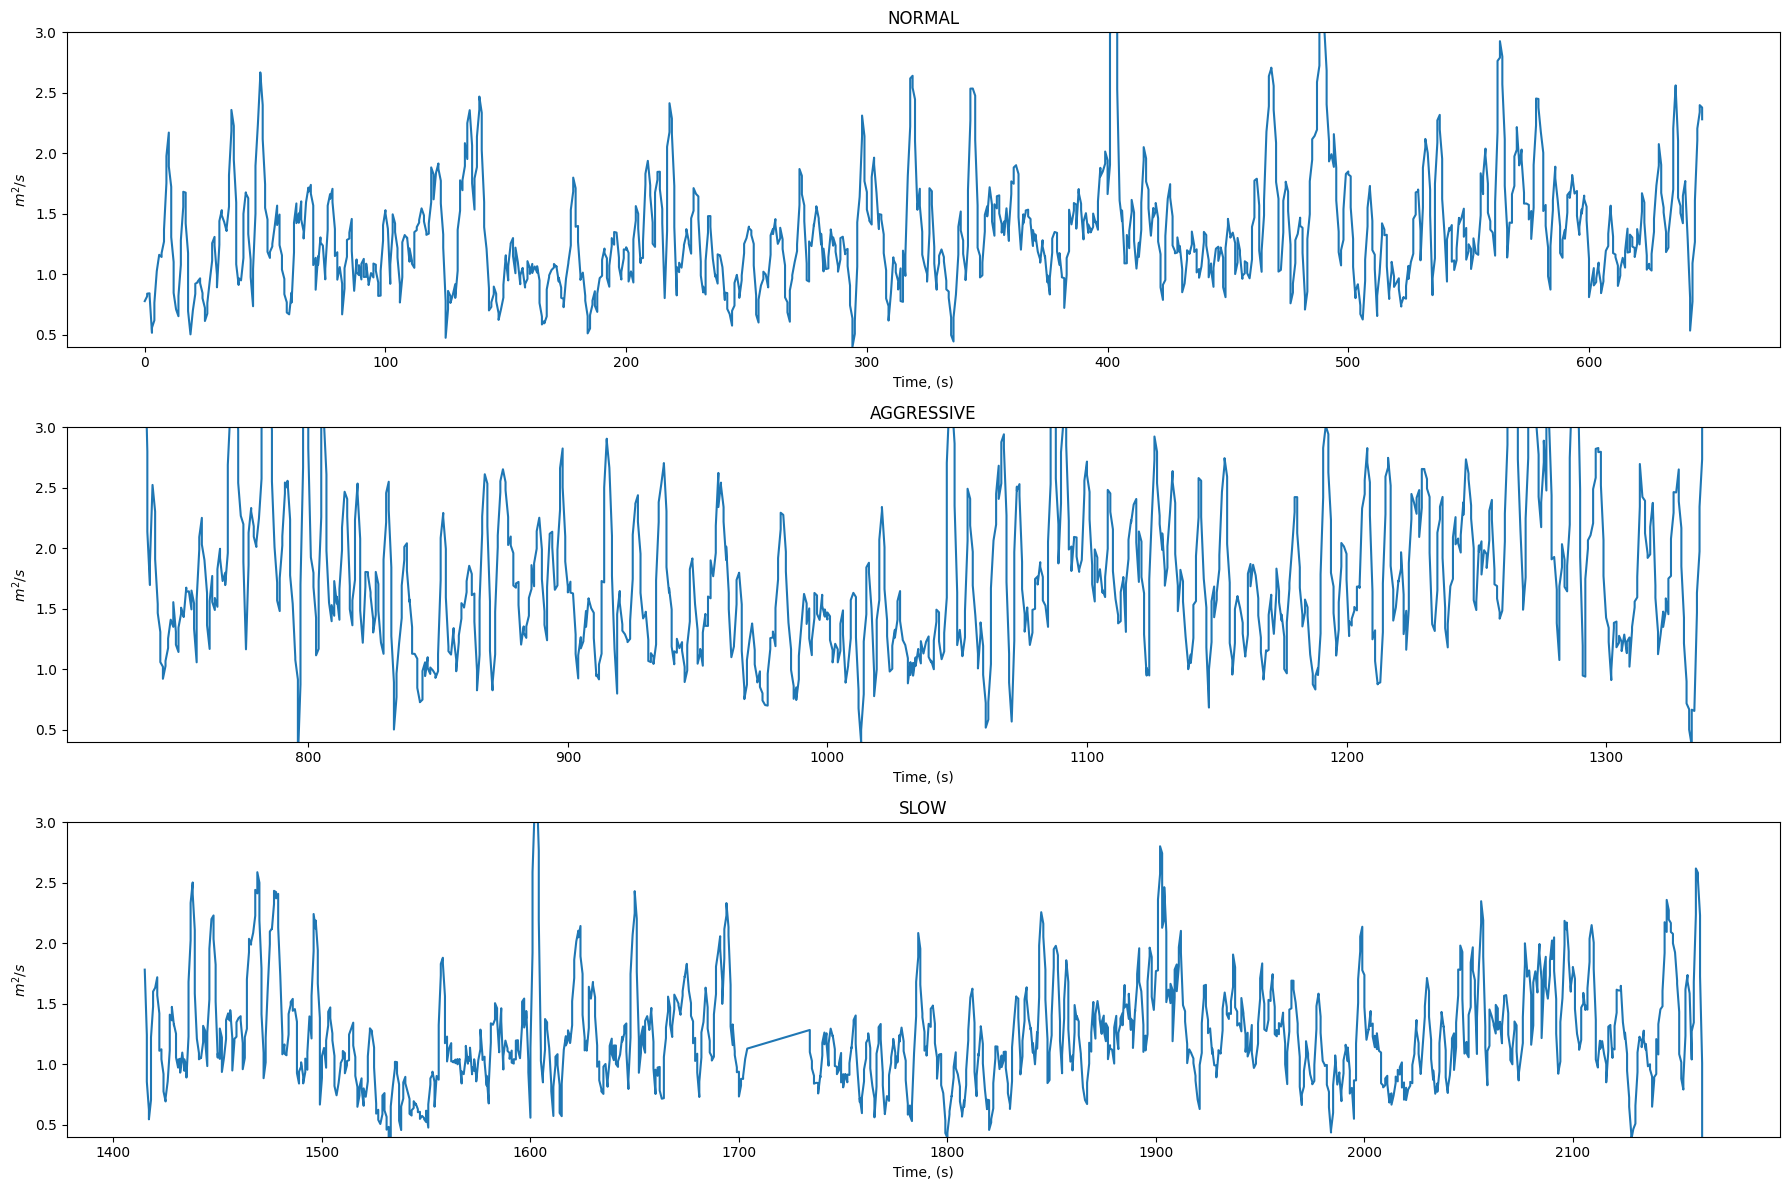

In [50]:
fig, axs = plt.subplots(3, 1, figsize=(18, 12))

for i in range(len(classes_train)):
    acc_length_train = vec_length(classes_train[i]['AccX'], classes_train[i]['AccY'], classes_train[i]['AccZ'])
    acc_length_test = vec_length(classes_test[i]['AccX'], classes_test[i]['AccY'], classes_test[i]['AccZ'])

    classes_train[i].loc[:,('Acc_vec')] = savgol_filter(acc_length_train, 10, 2)
    classes_test[i].loc[:,('Acc_vec')] = savgol_filter(acc_length_test, 10, 2)

    axs[i].plot(classes_train[i]['Timestamp'], savgol_filter(acc_length_train, 10, 2))
    axs[i].set_title(classes_train[i]['Class'].iloc[0])
    axs[i].set_ylim([0.4, 3])
    axs[i].set_xlabel('Time, (s)')
    axs[i].set_ylabel(r"$m^2/s$")
    
plt.tight_layout()
plt.show()

C:\Users\penai\AppData\Local\Temp\ipykernel_15600\2427408952.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  classes_train[i].loc[:,('Speed')] = Integrate_train.copy()
C:\Users\penai\AppData\Local\Temp\ipykernel_15600\2427408952.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  classes_test[i].loc[:,('Speed')] = Integrate_test.copy()
C:\Users\penai\AppData\Local\Temp\ipykernel_15600\2427408952.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usin

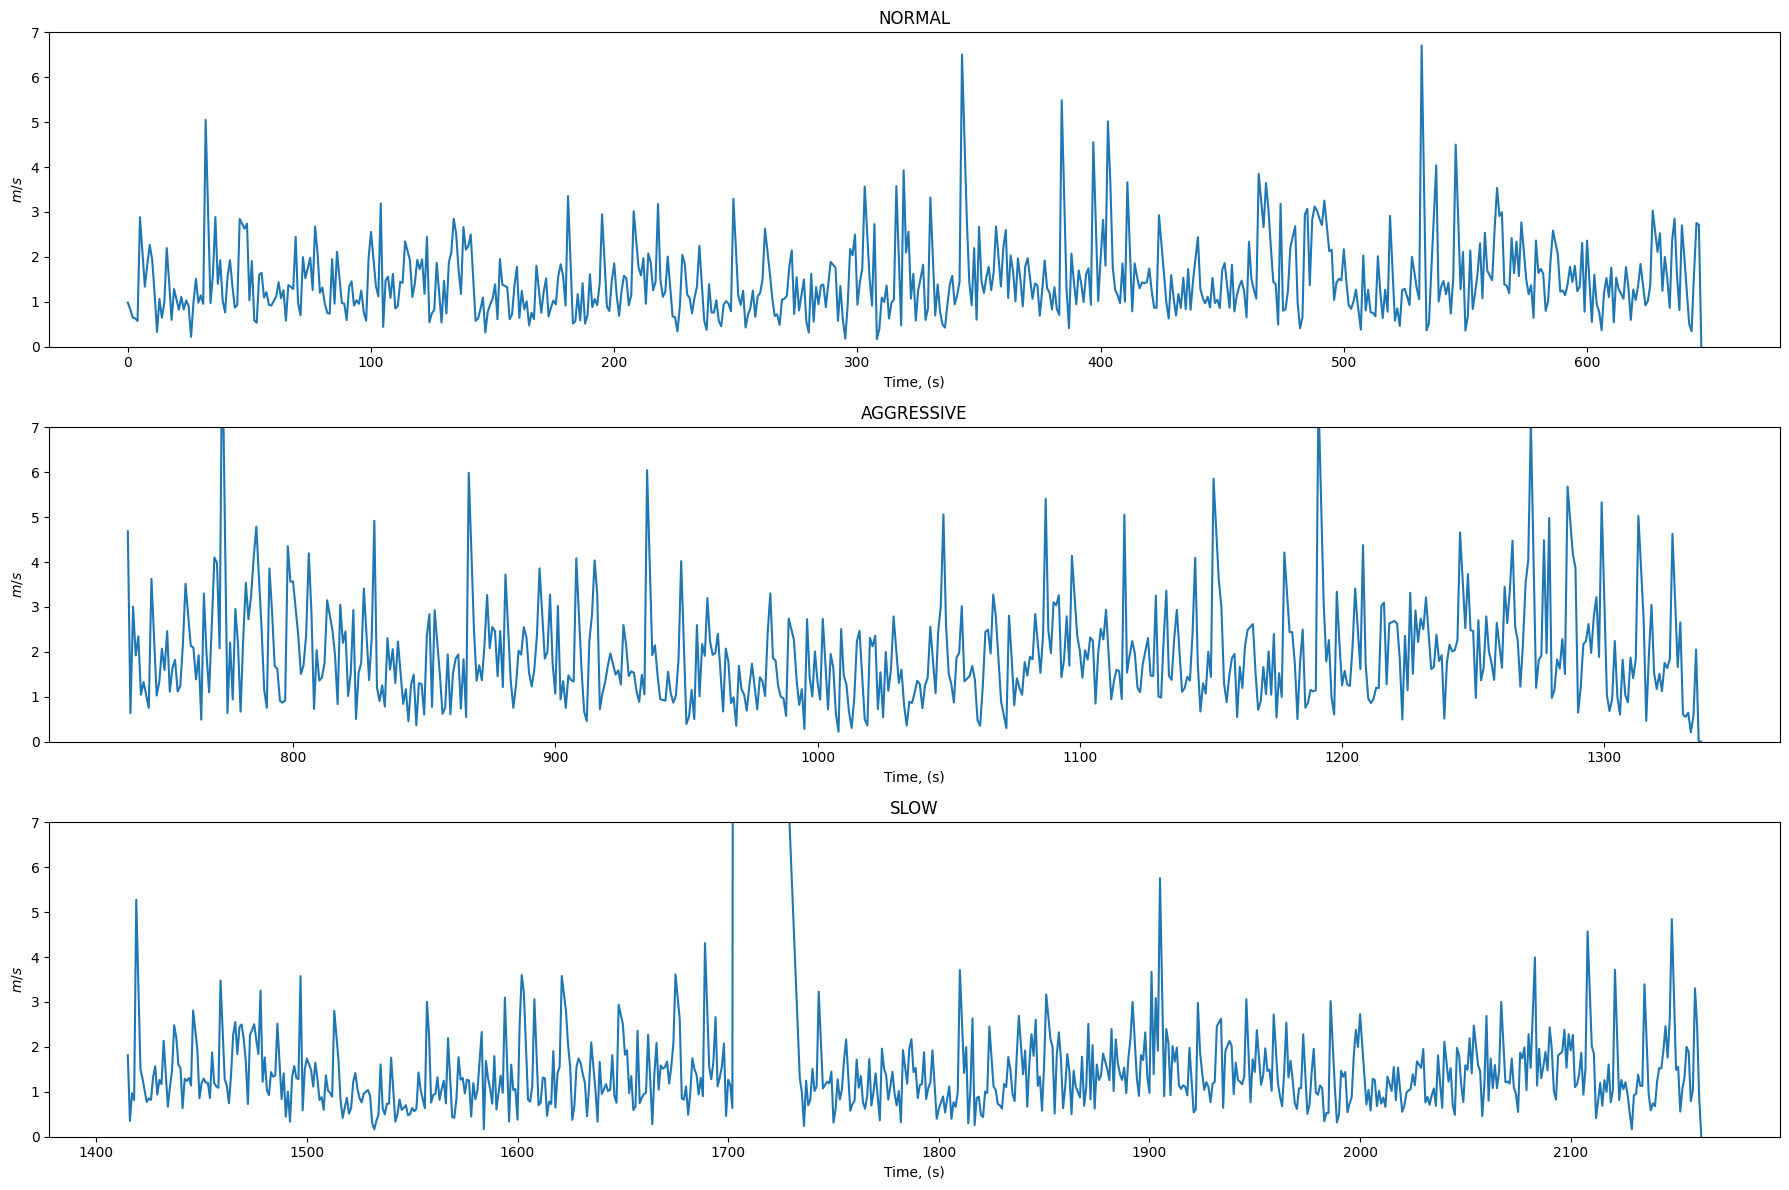

In [51]:
from scipy.integrate import quad

fig, axs = plt.subplots(3, 1, figsize=(18, 12))

def funcs(x, times, Comp_normals):
    return np.interp(x, times[first:second], Comp_normals[first:second])

for i in range(len(classes_train)):
    time_train = classes_train[i]['Timestamp']
    accel_data_train = np.column_stack((classes_train[i]['AccX'], classes_train[i]['AccY'], classes_train[i]['AccZ']))  # Simulated accelerometer data

    Comp_normal_train = vec_length(accel_data_train[:,0], accel_data_train[:,1],accel_data_train[:,2])

    time_step = 2
    Integrate_train = np.zeros(len(time_train))

    for separator in range(round(len(time_train)/time_step)-1):
        first = separator*time_step
        second = time_step+separator*time_step
        Integrate_train[first:second] = quad(funcs, time_train.iloc[first], time_train.iloc[second], args=(time_train, Comp_normal_train))[0]

    classes_train[i].loc[:,('Speed')] = Integrate_train.copy()

    time_test = classes_test[i]['Timestamp']
    accel_data_test = np.column_stack((classes_test[i]['AccX'], classes_test[i]['AccY'], classes_test[i]['AccZ']))  # Simulated accelerometer data

    Comp_normal_test = vec_length(accel_data_test[:,0], accel_data_test[:,1],accel_data_test[:,2])

    Integrate_test = np.zeros(len(time_test))

    for separator in range(round(len(time_test)/time_step)-1):
        first = separator*time_step
        second = time_step+separator*time_step
        Integrate_test[first:second] = quad(funcs, time_test.iloc[first], time_test.iloc[second], args=(time_test, Comp_normal_test))[0]

    classes_test[i].loc[:,('Speed')] = Integrate_test.copy()

    axs[i].plot(time_train[::time_step], Integrate_train[::time_step])
    axs[i].set_title(classes_train[i]['Class'].iloc[0])
    axs[i].set_ylim([0, 7])
    axs[i].set_xlabel('Time, (s)')
    axs[i].set_ylabel(r"$m/s$") 

plt.tight_layout()
plt.show()

In [52]:
def complementary_filter(accel_data, gyro_data, alpha=0.01, dt=0.5):
    rot_x = np.arctan2(accel_data[:,0], np.sqrt(accel_data[:,1]**2+accel_data[:,2]**2)) + gyro_data[:,0]*0.5
    rot_y = np.arctan2(accel_data[:,1], np.sqrt(accel_data[:,0]**2+accel_data[:,2]**2)) + gyro_data[:,1]*0.5
    rot_z = np.arctan2(accel_data[:,2], np.sqrt(accel_data[:,0]**2+accel_data[:,1]**2)) + gyro_data[:,2]*0.5

    # Complementary filter equation
    filtered_angle_x = alpha * (rot_x + gyro_data[:,0]*dt) + (1 - alpha) * (accel_data[:,0])
    filtered_angle_y = alpha * (rot_y + gyro_data[:,1]*dt) + (1 - alpha) * (accel_data[:,1])
    filtered_angle_z = alpha * (rot_z + gyro_data[:,2]*dt) + (1 - alpha) * (accel_data[:,2])
    return filtered_angle_x, filtered_angle_y, filtered_angle_z

C:\Users\penai\AppData\Local\Temp\ipykernel_15600\3189105547.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  classes_train[i].loc[:,('Pitch')] = pitch.copy()
C:\Users\penai\AppData\Local\Temp\ipykernel_15600\3189105547.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  classes_train[i].loc[:,('Roll')] = roll.copy()
C:\Users\penai\AppData\Local\Temp\ipykernel_15600\3189105547.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,c

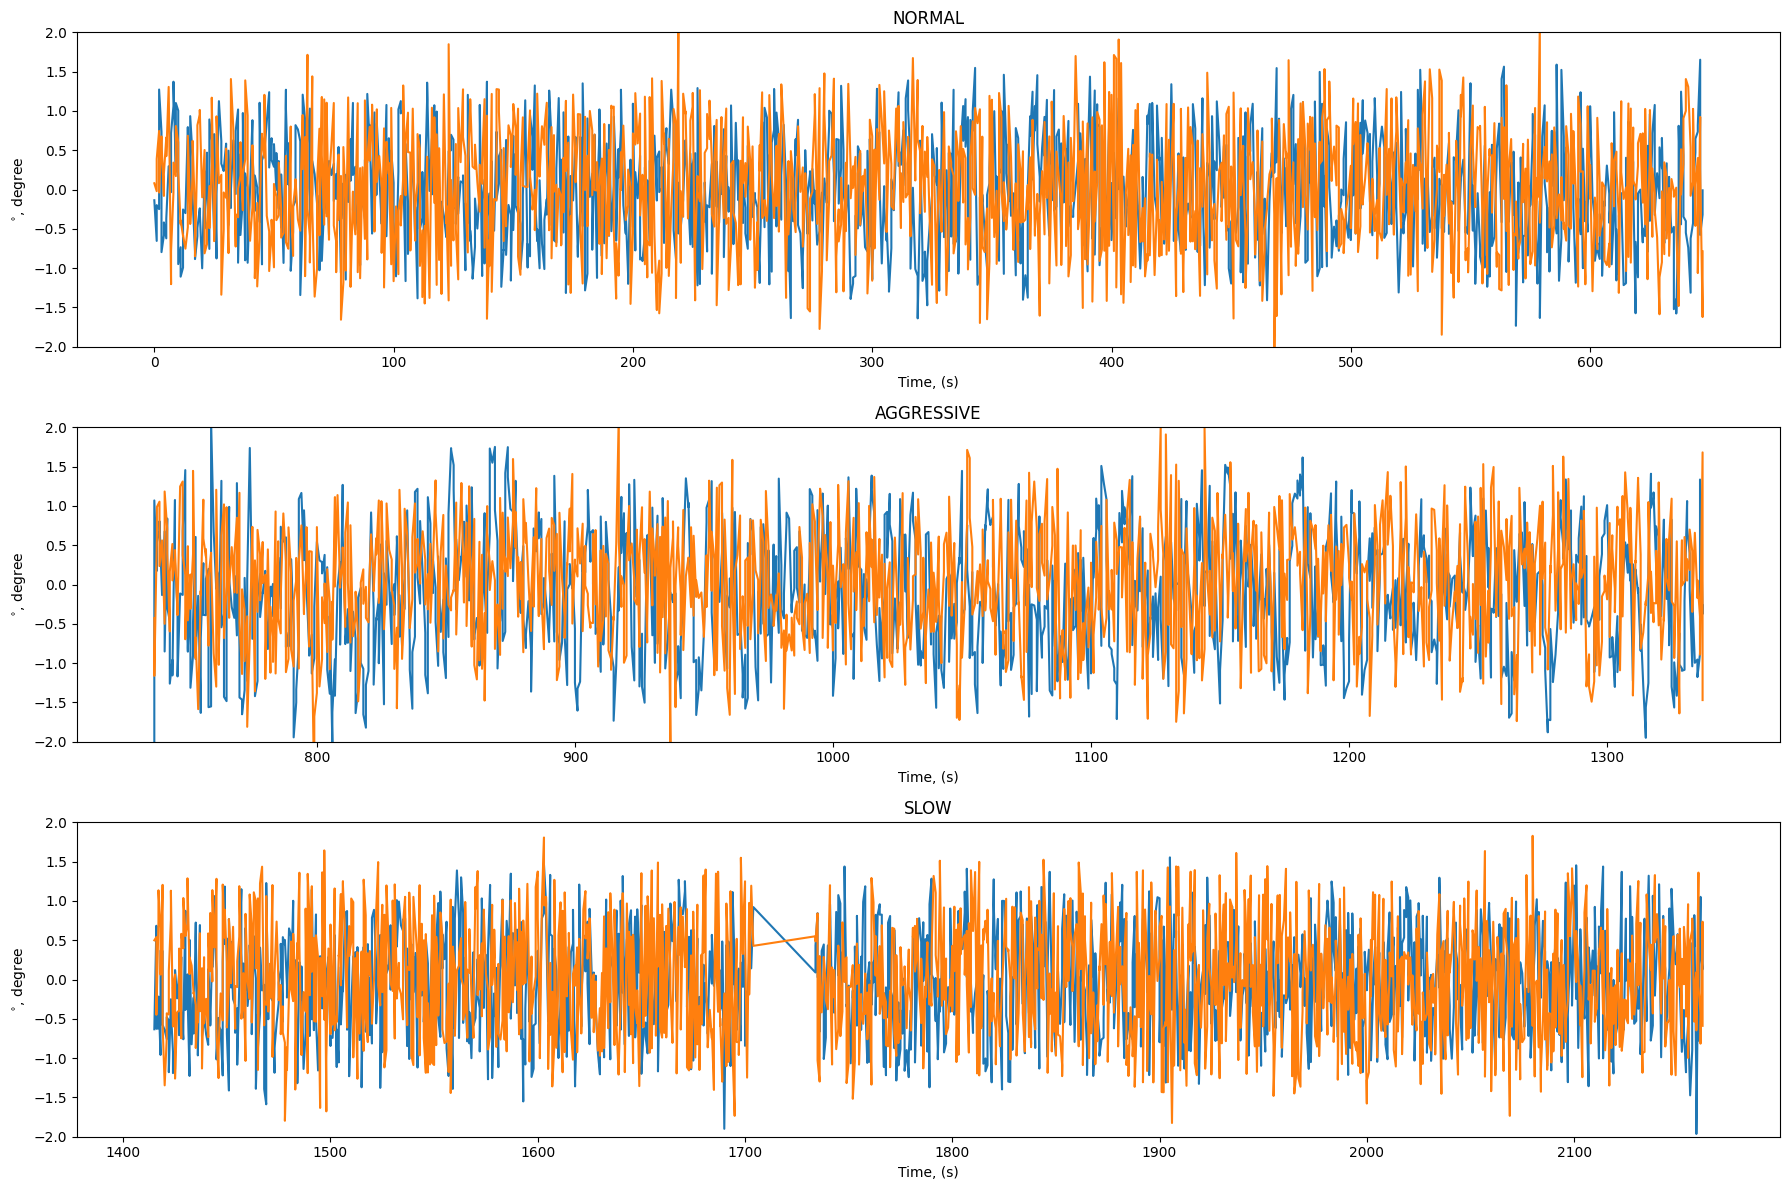

In [53]:
fig, axs = plt.subplots(3, 1, figsize=(18, 12))

for i in range(len(classes_train)):
    time = classes_train[i]['Timestamp']
    
    accel_data = np.column_stack((classes_train[i]['AccX'], classes_train[i]['AccY'], classes_train[i]['AccZ']))  # Simulated accelerometer data
    gyro_data = np.column_stack((classes_train[i]['GyroX'], classes_train[i]['GyroY'], classes_train[i]['GyroZ']))  # Simulated gyroscope data

    # Process data using complementary filter
    pitch, roll, yaw = complementary_filter(accel_data, gyro_data, alpha=0.78)

    classes_train[i].loc[:,('Pitch')] = pitch.copy()
    classes_train[i].loc[:,('Roll')] = roll.copy()
    classes_train[i].loc[:,('Yaw')] = yaw.copy()

    time_test = classes_test[i]['Timestamp']
    
    accel_data_test = np.column_stack((classes_test[i]['AccX'], classes_test[i]['AccY'], classes_test[i]['AccZ']))  # Simulated accelerometer data
    gyro_data_test = np.column_stack((classes_test[i]['GyroX'], classes_test[i]['GyroY'], classes_test[i]['GyroZ']))  # Simulated gyroscope data

    # Process data using complementary filter
    pitch_test, roll_test, yaw_test = complementary_filter(accel_data_test, gyro_data_test, alpha=0.78)

    classes_test[i].loc[:,('Pitch')] = pitch_test.copy()
    classes_test[i].loc[:,('Roll')] = roll_test.copy()
    classes_test[i].loc[:,('Yaw')] = yaw_test.copy()

    # axs[i].plot(time, pitch)
    axs[i].plot(time, roll)
    axs[i].plot(time, yaw)
    axs[i].set_ylim([-2, 2])
    axs[i].set_title(classes_train[i]['Class'].iloc[0])
    axs[i].set_xlabel('Time, (s)')
    axs[i].set_ylabel(r"$^{\circ}$, degree")

plt.tight_layout()
plt.show()

In [103]:
def Time_separator(data, time_step = 5):
    new_shape = (data.shape[0]//time_step, time_step)

    new_size = np.prod(new_shape)

    # Reduce the original array to match the new shape
    reduced_array = np.array(data[:new_size])

    return reduced_array.reshape(new_shape)

def Data_separator(classes, time_step = 5):
    X = []
    Y = []
    
    for i in range(len(classes)):
        dataset = classes[i]
        dataset = dataset.drop(['Timestamp'], axis=1)

        timeshots = np.stack([Time_separator(dataset[x], time_step) for x in list(dataset.drop(['Class'], axis=1))])
        
        timeshots = np.rollaxis(np.rollaxis(timeshots, 0, 2), 2, 1)

        classes_names = np.full(timeshots.shape[0], dataset['Class'].iloc[0]).T
        
        X.append(timeshots)
        Y.append(classes_names)

    return np.concatenate(X), np.concatenate(Y)


In [211]:
sep_time = 15

X_train, Y_train = Data_separator(classes_train, sep_time)
X_test, Y_test = Data_separator(classes_test, sep_time)

In [212]:
from sklearn.preprocessing import LabelEncoder

labelencoder_Y = LabelEncoder()

Y_train = labelencoder_Y.fit_transform(Y_train) 
Y_test = labelencoder_Y.transform(Y_test) 

In [213]:
from sklearn.utils import shuffle
X_train, Y_train = shuffle(X_train, Y_train, random_state=42)
X_test, Y_test = shuffle(X_test, Y_test, random_state=42)

In [214]:
def make_model(input_shape):
    input_layer = keras.layers.Input(input_shape)

    conv1 = keras.layers.Conv1D(filters=sep_time, kernel_size=3, padding="same")(input_layer)
    conv1 = keras.layers.BatchNormalization()(conv1)
    conv1 = keras.layers.ReLU()(conv1)

    conv2 = keras.layers.Conv1D(filters=sep_time, kernel_size=3, padding="same")(conv1)
    conv2 = keras.layers.BatchNormalization()(conv2)
    conv2 = keras.layers.ReLU()(conv2)

    conv3 = keras.layers.Conv1D(filters=sep_time, kernel_size=3, padding="same")(conv2)
    conv3 = keras.layers.BatchNormalization()(conv3)
    conv3 = keras.layers.ReLU()(conv3)

    gap = keras.layers.GlobalAveragePooling1D()(conv3)

    output_layer = keras.layers.Dense(num_classes, activation="softmax")(gap)

    return keras.models.Model(inputs=input_layer, outputs=output_layer)

num_classes = len(np.unique(Y_train))
model = make_model(input_shape=X_train.shape[1:])
keras.utils.plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [215]:
epochs = 200
batch_size = 50

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "best_model.keras", save_best_only=True, monitor="val_loss"
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=20, min_lr=0.0001
    ),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1),
]
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)
history = model.fit(
    X_train,
    Y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_split=0.2,
    verbose=2,
)

Epoch 1/200
4/4 - 2s - loss: 1.0496 - accuracy: 0.4301 - val_loss: 1.2705 - val_accuracy: 0.2857 - lr: 0.0010 - 2s/epoch - 610ms/step
Epoch 2/200
4/4 - 0s - loss: 1.0237 - accuracy: 0.4819 - val_loss: 1.2859 - val_accuracy: 0.2857 - lr: 0.0010 - 63ms/epoch - 16ms/step
Epoch 3/200
4/4 - 0s - loss: 0.9909 - accuracy: 0.5233 - val_loss: 1.3056 - val_accuracy: 0.2857 - lr: 0.0010 - 47ms/epoch - 12ms/step
Epoch 4/200
4/4 - 0s - loss: 0.9766 - accuracy: 0.5078 - val_loss: 1.3303 - val_accuracy: 0.2857 - lr: 0.0010 - 47ms/epoch - 12ms/step
Epoch 5/200
4/4 - 0s - loss: 0.9563 - accuracy: 0.5285 - val_loss: 1.3535 - val_accuracy: 0.2857 - lr: 0.0010 - 47ms/epoch - 12ms/step
Epoch 6/200
4/4 - 0s - loss: 0.9368 - accuracy: 0.5751 - val_loss: 1.3768 - val_accuracy: 0.2857 - lr: 0.0010 - 47ms/epoch - 12ms/step
Epoch 7/200
4/4 - 0s - loss: 0.9325 - accuracy: 0.5699 - val_loss: 1.3948 - val_accuracy: 0.2857 - lr: 0.0010 - 62ms/epoch - 16ms/step
Epoch 8/200
4/4 - 0s - loss: 0.9163 - accuracy: 0.5751 -

In [216]:
model = keras.models.load_model("best_model.keras")

test_loss, test_acc = model.evaluate(X_test, Y_test)

print("Test accuracy", test_acc)
print("Test loss", test_loss)

7/7 [==============================] - 0s 7ms/step - loss: 0.9098 - accuracy: 0.5441
Test accuracy 0.5441176295280457
Test loss 0.9098187685012817


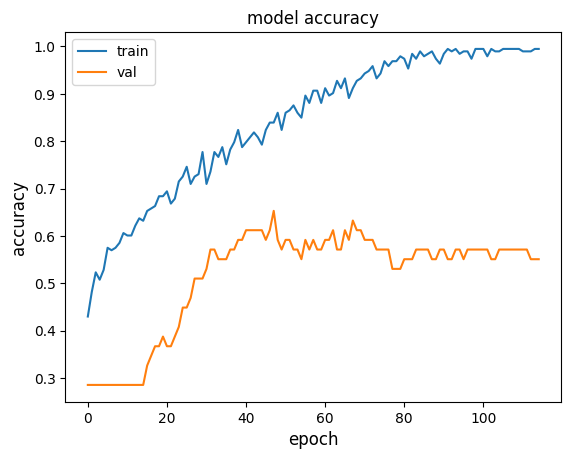

In [217]:
metric = "accuracy"
plt.figure()
plt.plot(history.history[metric])
plt.plot(history.history["val_" + metric])
plt.title("model " + metric)
plt.ylabel(metric, fontsize="large")
plt.xlabel("epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")
plt.show()
plt.close()

In [218]:
n_val = 30
epochs = 500
batch_size = 50
error_rate = []

for i in range(1,n_val):
    X_train, Y_train = Data_separator(classes_train, i)
    X_test, Y_test = Data_separator(classes_test, i)
    labelencoder_Y = LabelEncoder()

    Y_train = labelencoder_Y.fit_transform(Y_train) 
    Y_test = labelencoder_Y.transform(Y_test) 

    X_train, Y_train = shuffle(X_train, Y_train, random_state=42)
    X_test, Y_test = shuffle(X_test, Y_test, random_state=42)
    num_classes = len(np.unique(Y_train))
    model = make_model(input_shape=X_train.shape[1:])
    keras.utils.plot_model(model, show_shapes=True)

    callbacks = [
        keras.callbacks.ModelCheckpoint(
            "best_model.keras", save_best_only=True, monitor="val_loss"
        ),
        keras.callbacks.ReduceLROnPlateau(
            monitor="val_loss", factor=0.5, patience=20, min_lr=0.0001
        ),
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1),
    ]
    model.compile(
        optimizer="adam",
        loss="sparse_categorical_crossentropy",
        metrics=["sparse_categorical_accuracy"],
    )
    history = model.fit(
        X_train,
        Y_train,
        batch_size=batch_size,
        epochs=epochs,
        callbacks=callbacks,
        validation_split=0.2,
        verbose=0,
    )
    model = keras.models.load_model("best_model.keras")

    test_loss, test_acc = model.evaluate(X_test, Y_test)

    error_rate.append(test_acc)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
Epoch 89: early stopping
97/97 [==============================] - 1s 3ms/step - loss: 1.0321 - sparse_categorical_accuracy: 0.4578
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
Epoch 60: early stopping
49/49 [==============================] - 0s 2ms/step - loss: 1.0397 - sparse_categorical_accuracy: 0.4426
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
Epoch 64: early stopping
33/33 [==============================] - 1s 3ms/step - loss: 1.0236 - sparse_categorical_accuracy: 0.4654
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
Epoch 64: e

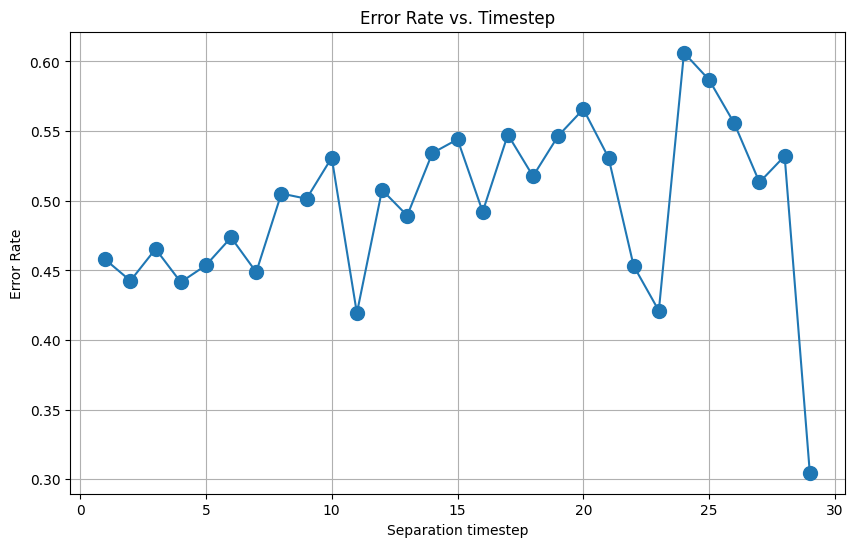

In [219]:
plt.figure(figsize=(10,6))
plt.plot(range(1,n_val), error_rate, marker='o', markersize=10)
plt.title('Error Rate vs. Timestep')
plt.xlabel('Separation timestep')
plt.ylabel('Error Rate')
plt.grid()

# Images

In [230]:
from matplotlib.image import imread
from PIL import Image
from keras.preprocessing.image import img_to_array, array_to_img
from keras.preprocessing import image
from keras.models import Sequential

from tensorflow.keras.layers import BatchNormalization

image_csv_train=pd.read_csv("img_train.csv")
image_csv_test=pd.read_csv("img_test.csv")

In [281]:
image_csv_train.head(10), image_csv_test.head(10)

(                                     id  label
 0  b1627fb5d6af156b41c46704bc041416.jpg      8
 1  bf61d61ec5f282372b76311e2594b94f.jpg     13
 2  1e963951fb29f4f37d9a153e14533d80.jpg     17
 3  4aec4a36181bd02af6040e3b4eef8378.jpg     14
 4  78740bc6ad7b6ca6fe572a580ffa65e0.jpg     16
 5  4caeafa514ae949eeeea54a71efd89c0.jpg      9
 6  c2063e258414f2f5ec511fda06288621.jpg      3
 7  cc34f29df0da071c3a8523b8d9478cbb.jpg      4
 8  c620c2b977426bb6122dd834846aebd6.jpg     19
 9  98f72a118aa838cd356d43d9546fcd39.jpg     18,
                                      id
 0  5f3540c43f86dab2c9a7c87834311ee3.jpg
 1  7f14db51f1994bce42972c7fe111f5cd.jpg
 2  092908960a3d4dccbe06a60b71dcdd98.jpg
 3  542ed4f107f9472457b47a436ec55e60.jpg
 4  c125af0d467cffe584728aad4b426d53.jpg
 5  dac637220376b2f834447c515148e301.jpg
 6  c94daf6d789e53fd933cb26cedf00678.jpg
 7  559cbbb343a27ec2839477c53b0ba65b.jpg
 8  4a6bd7247218fe3cd2001a634b1fd6df.jpg
 9  0598c5bd6d54bb7d9e3b7ece979a118c.jpg)

In [232]:
print(f"{len(image_csv_train.label.unique())}")

20


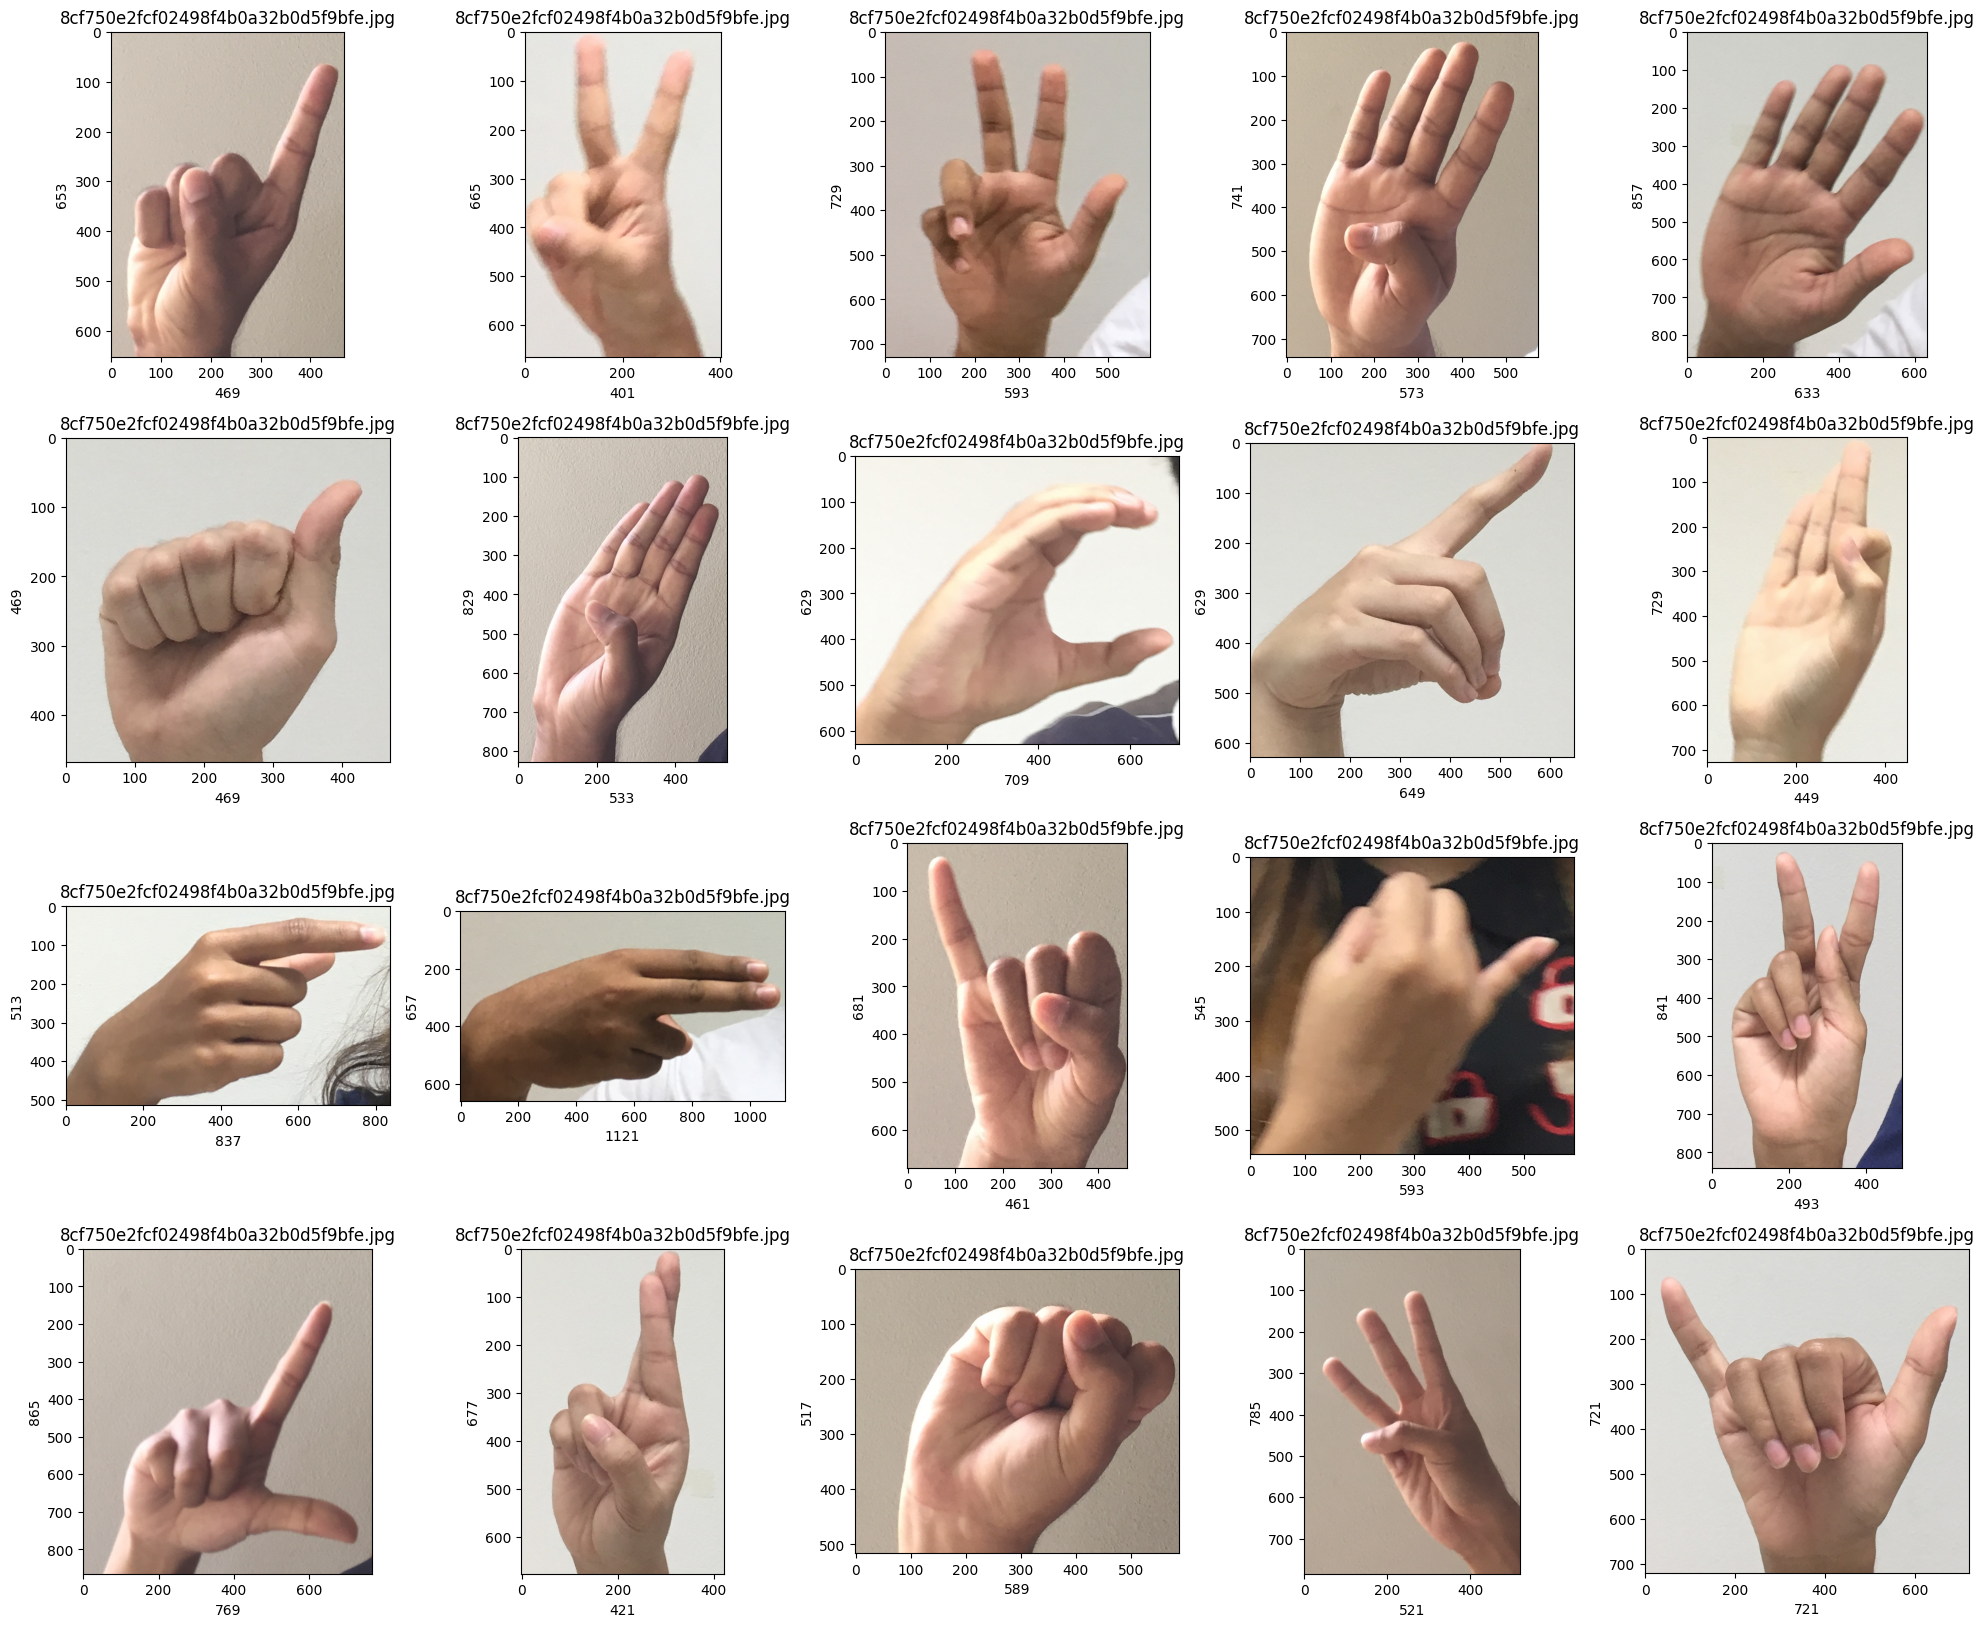

In [267]:
plt.figure(figsize=(20,20))
path = "images/train/"
for i in range(1, len(image_csv_train.label.unique())+1):
    plt.subplot(5,5,i)
    plt.tight_layout()
    selected_img = image_csv_train.groupby('label')['id'].first()[i-1]
    img = imread(path + selected_img)
    plt.imshow(img)
    plt.title(str(selected_folder))
    plt.xlabel(img.shape[1], fontsize = 10)
    plt.ylabel(img.shape[0], fontsize = 10)

In [294]:
train_image_list,train_label_list=[],[]
main_directory="images/train/"

for labels in image_csv_train['label'].unique():
    values = image_csv_train[image_csv_train['label'] == labels]['id'].tolist()

    for each_image in values:
        i=Image.open(f'{main_directory}/{each_image}')
        i=i.resize((100 ,100 ))
        image_array_format=img_to_array(i)
        train_image_list.append(image_array_format)
        train_label_list.append(labels)

In [295]:
total_Image_category_count=pd.DataFrame(train_label_list).value_counts()
total_Image_category_count

0     100
1     100
18    100
17    100
16    100
15    100
14    100
13    100
12    100
11    100
10    100
9     100
8     100
7     100
6     100
5     100
4     100
3     100
2     100
19    100
Name: count, dtype: int64

In [296]:
test_image_list=[]
main_directory="images/test/"
list_main_dir=listdir(main_directory)

for each in list_main_dir:
    i=Image.open(f'{main_directory}/{each}')
    i=i.resize((100 ,100 ))
    image_array_format=img_to_array(i)
    test_image_list.append(image_array_format)

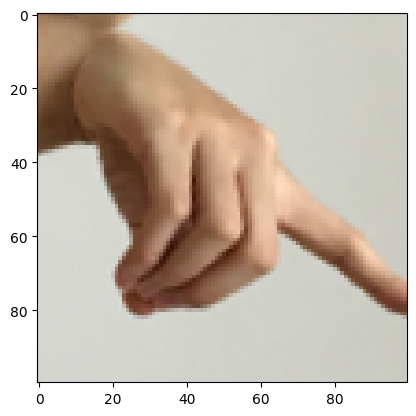

In [297]:
data_augmentation = keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.5),
])

train_image_list_aug=[]
for i in range(len(train_image_list)):
    for j in range(4):
        augmented_image = data_augmentation(train_image_list[i])
        train_image_list_aug.append(augmented_image)
train_image_list_aug = np.array(train_image_list_aug)
plt.figure()
plt.imshow(array_to_img(train_image_list_aug[1]))

In [300]:
lb = LabelBinarizer()
Y_image_train = lb.fit_transform(train_label_list)
print(lb.classes_)
Y_image_train.shape

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]


(2000, 20)

In [301]:
Y_image_train_aug=[]
for i in range(len(Y_image_train)):
    for j in range(4):
        Y_image_train_aug.append(Y_image_train[i,:])
Y_image_train_aug = np.array(Y_image_train_aug)
Y_image_train_aug.shape

(8000, 20)

In [313]:
train_image_list_aug.shape

(8000, 100, 100, 3)

In [317]:
model2 = Sequential()
model2.add(layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=train_image_list_aug.shape[1:]))
model2.add(layers.Conv2D(64, (3, 3), activation='relu'))
model2.add(layers.MaxPooling2D(pool_size=(2, 2)))
model2.add(layers.Dropout(0.25))
model2.add(layers.Flatten())
model2.add(layers.Dense(64, activation='relu'))
model2.add(layers.Dense(32, activation='sigmoid'))
model2.add(layers.Dropout(0.5))
model2.add(layers.Dense(Y_image_train_aug.shape[1], activation='softmax'))
model2.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 98, 98, 32)        896       
                                                                 
 conv2d_9 (Conv2D)           (None, 96, 96, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 48, 48, 64)        0         
 g2D)                                                            
                                                                 
 dropout_8 (Dropout)         (None, 48, 48, 64)        0         
                                                                 
 flatten_4 (Flatten)         (None, 147456)            0         
                                                                 
 dense_155 (Dense)           (None, 64)                9437248   
                                                      

In [318]:
from keras.optimizers import Adam
from keras.optimizers import SGD
opt2 = Adam(learning_rate=0.001)
model2.compile(optimizer=opt2,loss = 'categorical_crossentropy', metrics=['accuracy'])

In [320]:
history2 = model2.fit(train_image_list_aug, Y_image_train_aug, batch_size = 256, epochs = 500)

Epoch 1/500
32/32 [==============================] - 163s 5s/step - loss: 3.0416 - accuracy: 0.0534
Epoch 2/500
32/32 [==============================] - 136s 4s/step - loss: 3.0406 - accuracy: 0.0510
Epoch 3/500
32/32 [==============================] - 136s 4s/step - loss: 3.0337 - accuracy: 0.0501
Epoch 4/500
32/32 [==============================] - 140s 4s/step - loss: 3.0286 - accuracy: 0.0510
Epoch 5/500
32/32 [==============================] - 130s 4s/step - loss: 3.0273 - accuracy: 0.0480
Epoch 6/500
32/32 [==============================] - 129s 4s/step - loss: 3.0201 - accuracy: 0.0535
Epoch 7/500
32/32 [==============================] - 130s 4s/step - loss: 3.0218 - accuracy: 0.0479
Epoch 8/500
32/32 [==============================] - 139s 4s/step - loss: 3.0127 - accuracy: 0.0485
Epoch 9/500
31/32 [============================>.] - ETA: 4s - loss: 3.0117 - accuracy: 0.0509

## Import data

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
Text_data = pd.read_csv('data_amazon.csv')


In [ ]:
Text_data = Text_data.iloc[:, 1:3].dropna()

In [ ]:
from collections import Counter
Counter(Text_data['Cons_rating'])

Counter({4.0: 8104, 5.0: 27783, 3.0: 5307, 2.0: 3303, 1.0: 3798})

In [ ]:
X_text_train = Text_data.iloc[:, 0] #Review
Y_text_train = Text_data.iloc[:, 1] #Raiting

In [ ]:
from imblearn.under_sampling import RandomUnderSampler

undersampler = RandomUnderSampler()

X_text_simpl, Y_text_simpl = undersampler.fit_resample(np.array(X_text_train).reshape(-1, 1), np.array(Y_text_train).reshape(-1, 1))
Text_data_simp = pd.DataFrame({'Review': X_text_simpl.reshape(Y_text_simpl.shape), 'Cons_rating': Y_text_simpl})

In [ ]:
Counter(Text_data_simp['Cons_rating'])

Counter({1.0: 3303, 2.0: 3303, 3.0: 3303, 4.0: 3303, 5.0: 3303})

## Text cleaning and vectorization

In [ ]:
from sklearn.model_selection import train_test_split
X_text_train, X_text_test, Y_text_train, Y_text_test = train_test_split(Text_data_simp['Review'], Text_data_simp['Cons_rating'], test_size=0.20)

In [ ]:
labelencoder_text = LabelEncoder()
Y_text_train = labelencoder_text.fit_transform(Y_text_train) 
Y_text_test = labelencoder_text.transform(Y_text_test) 

In [ ]:
vectorizer = CountVectorizer(stop_words='english', ngram_range=(1, 2))
X_text_train_transformed = vectorizer.fit_transform(X_text_train)
X_text_test_transformed = vectorizer.transform(X_text_test)

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
max_words = 1000
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_text_train)
X_train_seq = tokenizer.texts_to_sequences(X_text_train)
X_test_seq = tokenizer.texts_to_sequences(X_text_test)

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
# Padding 
max_sequence_length = 100
X_train_pad = pad_sequences(X_train_seq, maxlen=max_sequence_length)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_sequence_length)

In [ ]:
from tensorflow import keras
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from tensorflow.keras.callbacks import EarlyStopping
model3 = keras.Sequential()
model3.add(Embedding(input_dim=max_words, output_dim=128, input_length=max_sequence_length))
model3.add(LSTM(100))
model3.add(Dense(3, activation='sigmoid'))
model3.add(Dense(3, activation='softmax'))  # 3 output classes

In [ ]:
model3.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
model3.summary()

In [ ]:
model3.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
epochs = 20
batch_size = 64
history = model3.fit(X_train_pad, Y_text_train, epochs=epochs, batch_size=batch_size)

In [ ]:
loss, accuracy = model3.evaluate(X_test_pad, Y_text_test)
print(f'Loss: {loss:.4f}')
print(f'Accuracy: {accuracy:.4f}')